2025-04-05 17:14:27 - INFO - CSV 파일 로딩 시작: c:\Users\kimbo\NNL\AI-PDR_GPS-GT\data\learn_data\Basket_1.csv
2025-04-05 17:14:27 - INFO - CSV 파일 로딩 완료: 5695 행
2025-04-05 17:14:27 - INFO - 컬럼 이름 재정의 완료
2025-04-05 17:14:27 - INFO - 시간 데이터 전처리 시작
2025-04-05 17:14:27 - INFO - 시간 데이터 전처리 완료
2025-04-05 17:14:27 - INFO - GPS 데이터 전처리 시작
2025-04-05 17:14:27 - INFO - ENU 좌표 변환 시작
2025-04-05 17:14:37 - INFO - ENU 좌표 변환 완료
2025-04-05 17:14:37 - INFO - GPS 데이터 전처리 완료
2025-04-05 17:14:37 - INFO - 가속도 벡터 크기 계산 시작
2025-04-05 17:14:37 - INFO - 가속도 벡터 크기 계산 완료
2025-04-05 17:14:37 - INFO - 속도 및 헤딩 계산 시작
2025-04-05 17:14:37 - INFO - 속도 및 헤딩 계산 시작
2025-04-05 17:14:37 - INFO - 속도 및 헤딩 계산 완료
2025-04-05 17:14:37 - INFO - 속도 및 헤딩 계산 완료
2025-04-05 17:14:37 - INFO - 전체 전처리 완료
2025-04-05 17:14:37 - INFO - CSV 파일 로딩 시작: c:\Users\kimbo\NNL\AI-PDR_GPS-GT\data\learn_data\Basket_2.csv
2025-04-05 17:14:37 - INFO - CSV 파일 로딩 완료: 8756 행
2025-04-05 17:14:37 - INFO - 컬럼 이름 재정의 완료
2025-04-05 17:14:37 - INFO - 시간 데이터 전처리 시작
2025


=== 스케일링 전/후 통계 정보 ===

Accelerometer:

x-axis:
       Original    Scaled
Min   -5.898308 -1.000000
Max   18.862621  1.000000
Mean   3.148814 -0.269242
Std    3.671980  0.296595

y-axis:
       Original    Scaled
Min  -17.218752 -1.000000
Max   11.155339  1.000000
Mean  -2.200708  0.058574
Std    7.370738  0.519540

z-axis:
       Original    Scaled
Min   -9.068798 -1.000000
Max   19.123438  1.000000
Mean   5.112585  0.006049
Std    4.801178  0.340603

Gyroscope:

x-axis:
      Original    Scaled
Min  -2.579224 -1.000000
Max   3.068374  1.000000
Mean -0.032755 -0.098212
Std   0.427029  0.151225

y-axis:
      Original    Scaled
Min  -4.571636 -1.000000
Max   4.195648  1.000000
Mean -0.013784  0.039741
Std   0.640378  0.146084

z-axis:
      Original    Scaled
Min  -6.276712 -1.000000
Max   5.850939  1.000000
Mean  0.007349  0.036320
Std   1.815250  0.299357

Orientation:

x-axis:
      Original    Scaled
Min  -0.824482 -1.000000
Max   0.809309  1.000000
Mean -0.069115 -0.075321
Std   

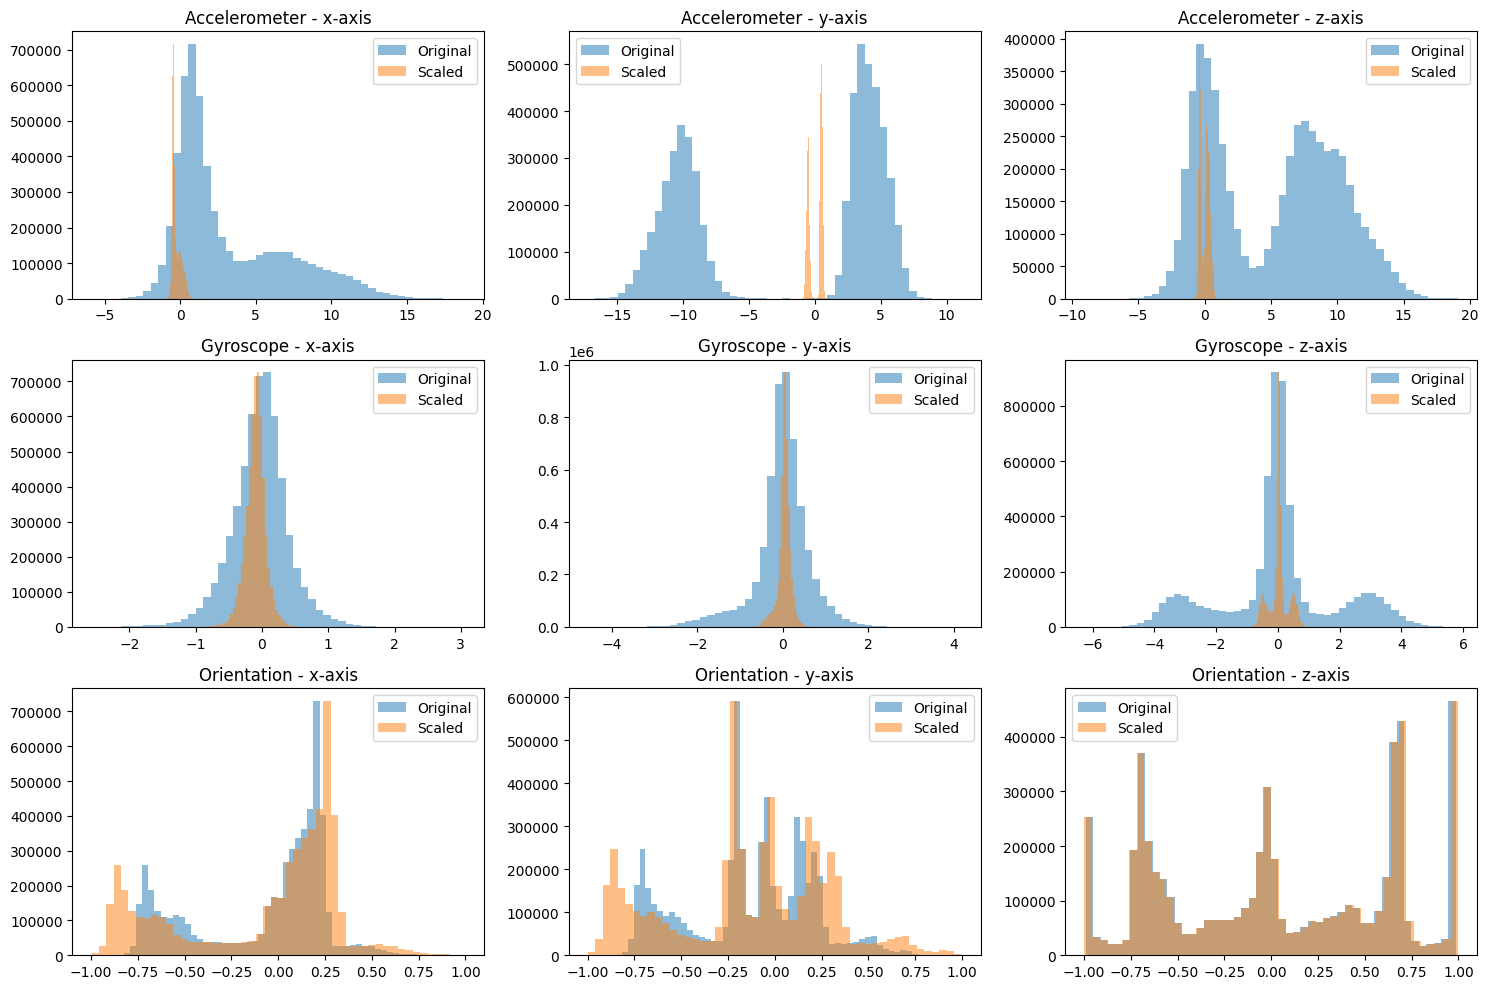

Epoch 1/100
683/683 [==============================] - 10s 11ms/step - loss: 1.2272 - mae: 0.3649 - val_loss: 1.4672 - val_mae: 0.3427
Epoch 2/100
683/683 [==============================] - 7s 10ms/step - loss: 0.8954 - mae: 0.3123 - val_loss: 1.1232 - val_mae: 0.3172
Epoch 3/100
683/683 [==============================] - 7s 10ms/step - loss: 0.7605 - mae: 0.2910 - val_loss: 0.7915 - val_mae: 0.2760
Epoch 4/100
683/683 [==============================] - 7s 10ms/step - loss: 0.6675 - mae: 0.2753 - val_loss: 0.8127 - val_mae: 0.2520
Epoch 5/100
683/683 [==============================] - 7s 10ms/step - loss: 0.6167 - mae: 0.2616 - val_loss: 0.5682 - val_mae: 0.2461
Epoch 6/100
683/683 [==============================] - 7s 10ms/step - loss: 0.9729 - mae: 0.3155 - val_loss: 1.5142 - val_mae: 0.4110
Epoch 7/100
683/683 [==============================] - 7s 10ms/step - loss: 1.3045 - mae: 0.3721 - val_loss: 1.2091 - val_mae: 0.3460
Epoch 8/100
683/683 [==============================] - 7s 10m

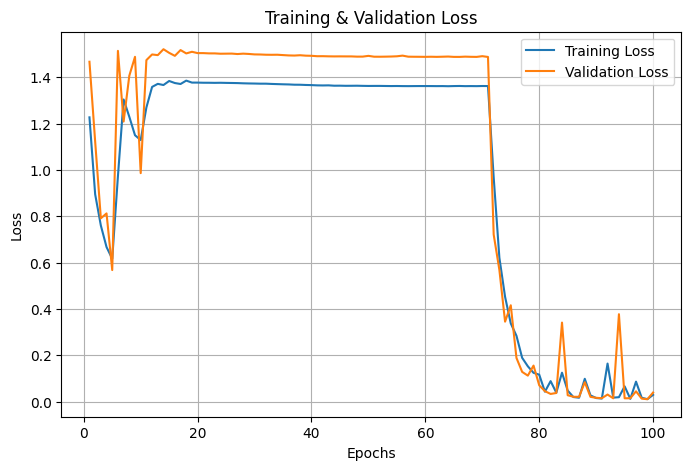

2025-04-05 17:29:31 - INFO - CSV 파일 로딩 시작: c:\Users\kimbo\NNL\AI-PDR_GPS-GT\data\test_data\3f_1.csv
2025-04-05 17:29:31 - INFO - CSV 파일 로딩 완료: 2590 행
2025-04-05 17:29:31 - INFO - 컬럼 이름 재정의 완료
2025-04-05 17:29:31 - INFO - 시간 데이터 전처리 시작
2025-04-05 17:29:31 - INFO - 시간 데이터 전처리 완료
2025-04-05 17:29:31 - INFO - GPS 데이터 전처리 시작
2025-04-05 17:29:31 - INFO - ENU 좌표 변환 시작


모델이 저장되었습니다: saved_models\model_20250405_172931.h5


2025-04-05 17:29:35 - INFO - ENU 좌표 변환 완료
2025-04-05 17:29:35 - INFO - GPS 데이터 전처리 완료
2025-04-05 17:29:35 - INFO - 가속도 벡터 크기 계산 시작
2025-04-05 17:29:35 - INFO - 가속도 벡터 크기 계산 완료
2025-04-05 17:29:35 - INFO - 속도 및 헤딩 계산 시작
2025-04-05 17:29:35 - INFO - 속도 및 헤딩 계산 시작
2025-04-05 17:29:35 - INFO - 속도 및 헤딩 계산 완료
2025-04-05 17:29:35 - INFO - 속도 및 헤딩 계산 완료
2025-04-05 17:29:35 - INFO - 전체 전처리 완료


2/2 [==============================] - 0s 0s/step


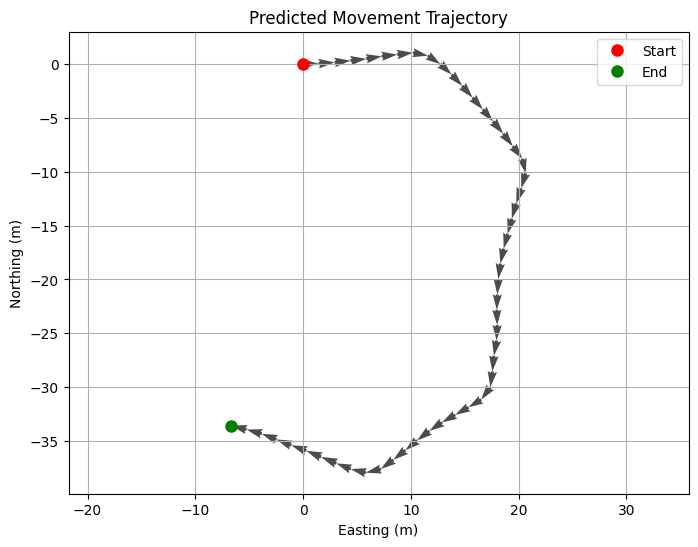

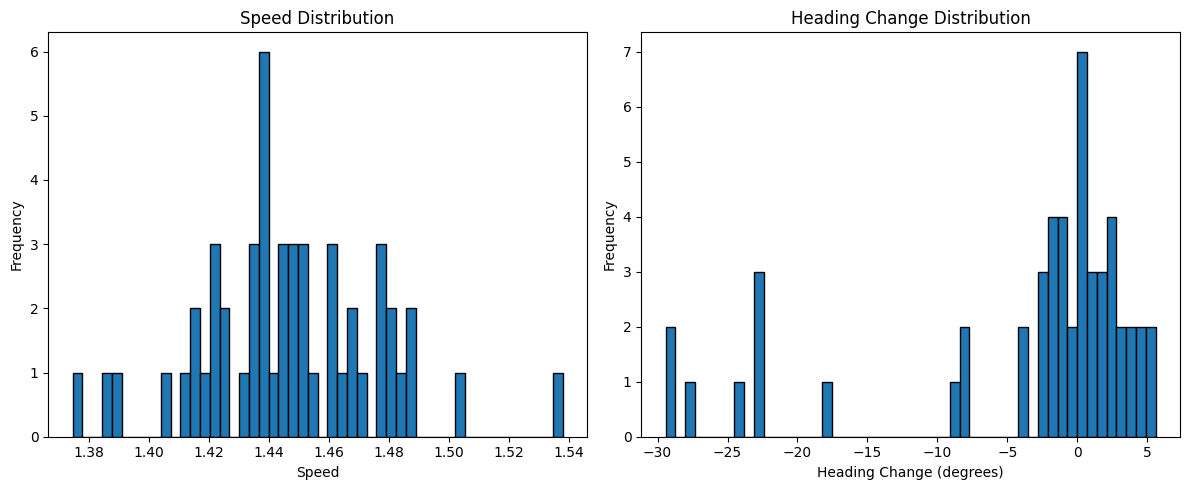

2025-04-05 17:29:36 - INFO - CSV 파일 로딩 시작: c:\Users\kimbo\NNL\AI-PDR_GPS-GT\data\test_data\3f_2.csv
2025-04-05 17:29:36 - INFO - CSV 파일 로딩 완료: 2618 행
2025-04-05 17:29:36 - INFO - 컬럼 이름 재정의 완료
2025-04-05 17:29:36 - INFO - 시간 데이터 전처리 시작
2025-04-05 17:29:36 - INFO - 시간 데이터 전처리 완료
2025-04-05 17:29:36 - INFO - GPS 데이터 전처리 시작
2025-04-05 17:29:36 - INFO - ENU 좌표 변환 시작
2025-04-05 17:29:41 - INFO - ENU 좌표 변환 완료
2025-04-05 17:29:41 - INFO - GPS 데이터 전처리 완료
2025-04-05 17:29:41 - INFO - 가속도 벡터 크기 계산 시작
2025-04-05 17:29:41 - INFO - 가속도 벡터 크기 계산 완료
2025-04-05 17:29:41 - INFO - 속도 및 헤딩 계산 시작
2025-04-05 17:29:41 - INFO - 속도 및 헤딩 계산 시작
2025-04-05 17:29:41 - INFO - 속도 및 헤딩 계산 완료
2025-04-05 17:29:41 - INFO - 속도 및 헤딩 계산 완료
2025-04-05 17:29:41 - INFO - 전체 전처리 완료


2/2 [==============================] - 0s 8ms/step


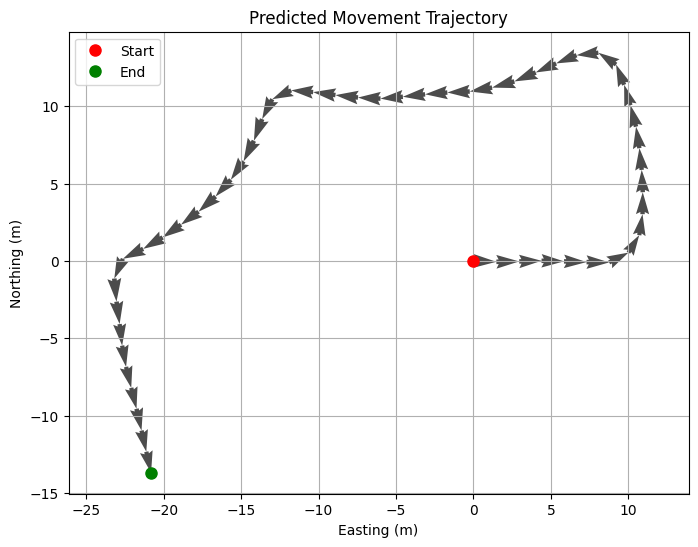

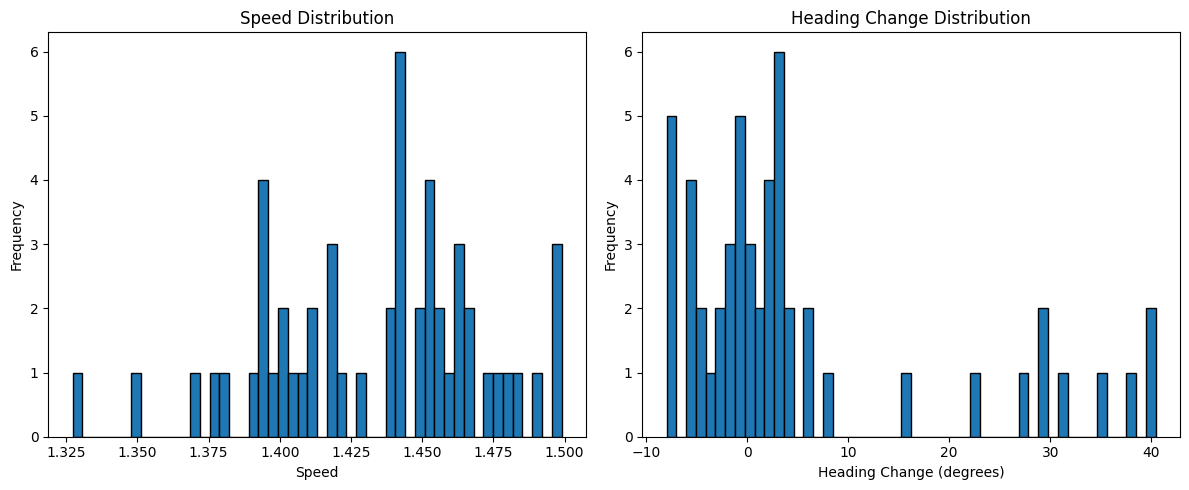

2025-04-05 17:29:41 - INFO - CSV 파일 로딩 시작: c:\Users\kimbo\NNL\AI-PDR_GPS-GT\data\test_data\3f_swing1.csv
2025-04-05 17:29:41 - INFO - CSV 파일 로딩 완료: 2699 행
2025-04-05 17:29:41 - INFO - 컬럼 이름 재정의 완료
2025-04-05 17:29:41 - INFO - 시간 데이터 전처리 시작
2025-04-05 17:29:41 - INFO - 시간 데이터 전처리 완료
2025-04-05 17:29:41 - INFO - GPS 데이터 전처리 시작
2025-04-05 17:29:41 - INFO - ENU 좌표 변환 시작
2025-04-05 17:29:46 - INFO - ENU 좌표 변환 완료
2025-04-05 17:29:46 - INFO - GPS 데이터 전처리 완료
2025-04-05 17:29:46 - INFO - 가속도 벡터 크기 계산 시작
2025-04-05 17:29:46 - INFO - 가속도 벡터 크기 계산 완료
2025-04-05 17:29:46 - INFO - 속도 및 헤딩 계산 시작
2025-04-05 17:29:46 - INFO - 속도 및 헤딩 계산 시작
2025-04-05 17:29:46 - INFO - 속도 및 헤딩 계산 완료
2025-04-05 17:29:46 - INFO - 속도 및 헤딩 계산 완료
2025-04-05 17:29:46 - INFO - 전체 전처리 완료


2/2 [==============================] - 0s 16ms/step


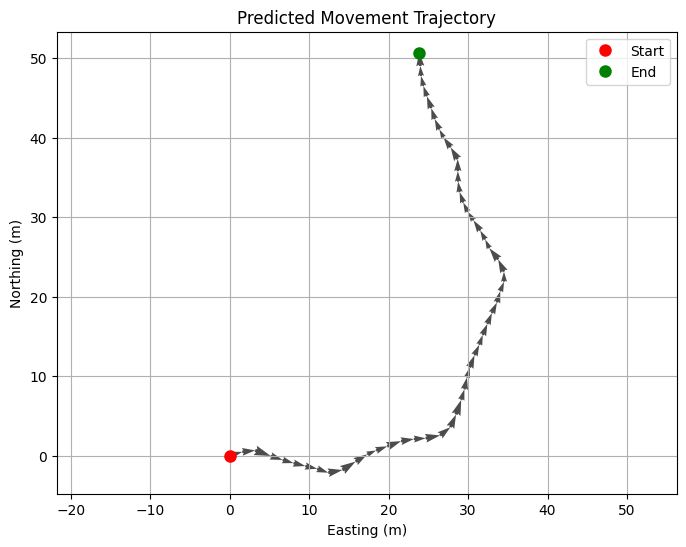

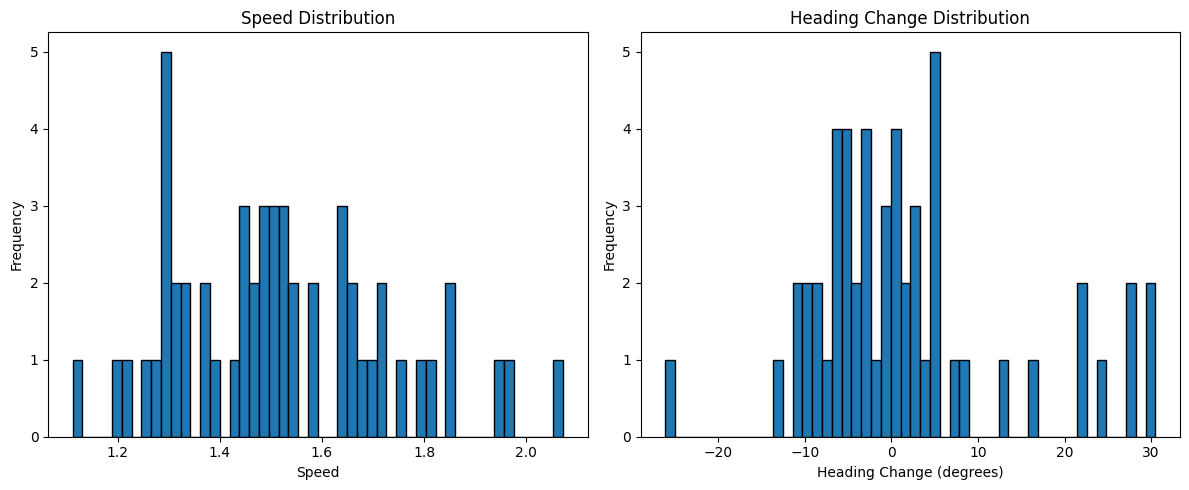

2025-04-05 17:29:47 - INFO - CSV 파일 로딩 시작: c:\Users\kimbo\NNL\AI-PDR_GPS-GT\data\test_data\3f_swing2.csv
2025-04-05 17:29:47 - INFO - CSV 파일 로딩 완료: 2683 행
2025-04-05 17:29:47 - INFO - 컬럼 이름 재정의 완료
2025-04-05 17:29:47 - INFO - 시간 데이터 전처리 시작
2025-04-05 17:29:47 - INFO - 시간 데이터 전처리 완료
2025-04-05 17:29:47 - INFO - GPS 데이터 전처리 시작
2025-04-05 17:29:47 - INFO - ENU 좌표 변환 시작
2025-04-05 17:29:51 - INFO - ENU 좌표 변환 완료
2025-04-05 17:29:51 - INFO - GPS 데이터 전처리 완료
2025-04-05 17:29:51 - INFO - 가속도 벡터 크기 계산 시작
2025-04-05 17:29:51 - INFO - 가속도 벡터 크기 계산 완료
2025-04-05 17:29:51 - INFO - 속도 및 헤딩 계산 시작
2025-04-05 17:29:51 - INFO - 속도 및 헤딩 계산 시작
2025-04-05 17:29:51 - INFO - 속도 및 헤딩 계산 완료
2025-04-05 17:29:51 - INFO - 속도 및 헤딩 계산 완료
2025-04-05 17:29:51 - INFO - 전체 전처리 완료


2/2 [==============================] - 0s 8ms/step


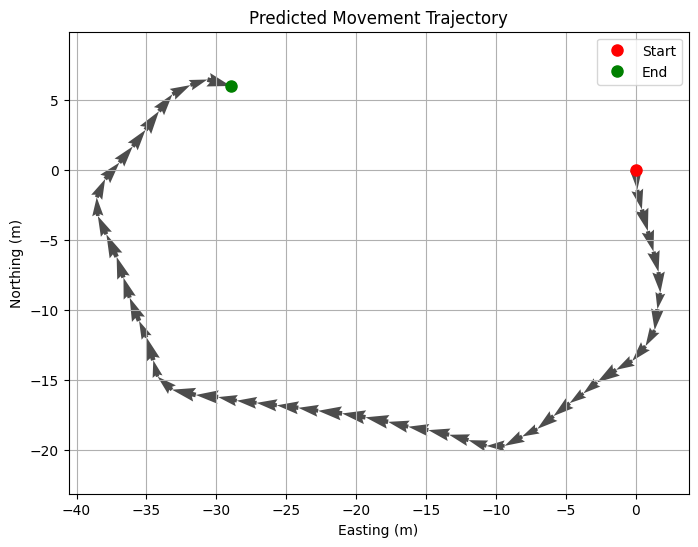

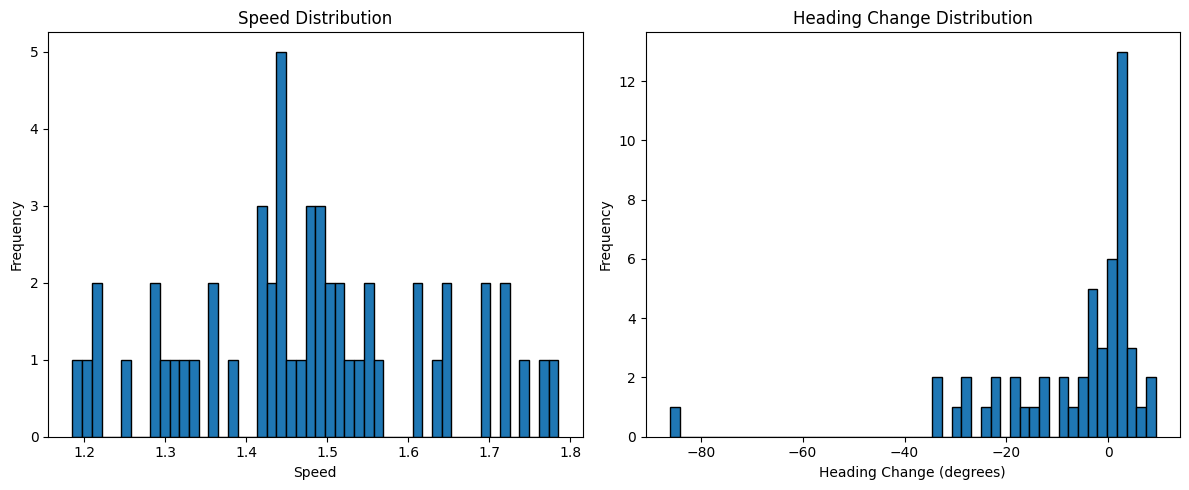

2025-04-05 17:29:52 - INFO - CSV 파일 로딩 시작: c:\Users\kimbo\NNL\AI-PDR_GPS-GT\data\test_data\3f_looking01.csv
2025-04-05 17:29:52 - INFO - CSV 파일 로딩 완료: 2515 행
2025-04-05 17:29:52 - INFO - 컬럼 이름 재정의 완료
2025-04-05 17:29:52 - INFO - 시간 데이터 전처리 시작
2025-04-05 17:29:52 - INFO - 시간 데이터 전처리 완료
2025-04-05 17:29:52 - INFO - GPS 데이터 전처리 시작
2025-04-05 17:29:52 - INFO - ENU 좌표 변환 시작
2025-04-05 17:29:56 - INFO - ENU 좌표 변환 완료
2025-04-05 17:29:56 - INFO - GPS 데이터 전처리 완료
2025-04-05 17:29:56 - INFO - 가속도 벡터 크기 계산 시작
2025-04-05 17:29:56 - INFO - 가속도 벡터 크기 계산 완료
2025-04-05 17:29:56 - INFO - 속도 및 헤딩 계산 시작
2025-04-05 17:29:56 - INFO - 속도 및 헤딩 계산 시작
2025-04-05 17:29:56 - INFO - 속도 및 헤딩 계산 완료
2025-04-05 17:29:56 - INFO - 속도 및 헤딩 계산 완료
2025-04-05 17:29:56 - INFO - 전체 전처리 완료


2/2 [==============================] - 0s 16ms/step


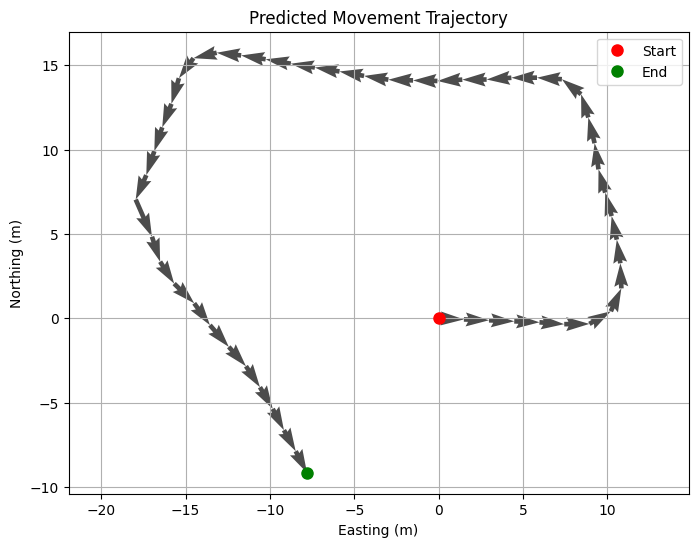

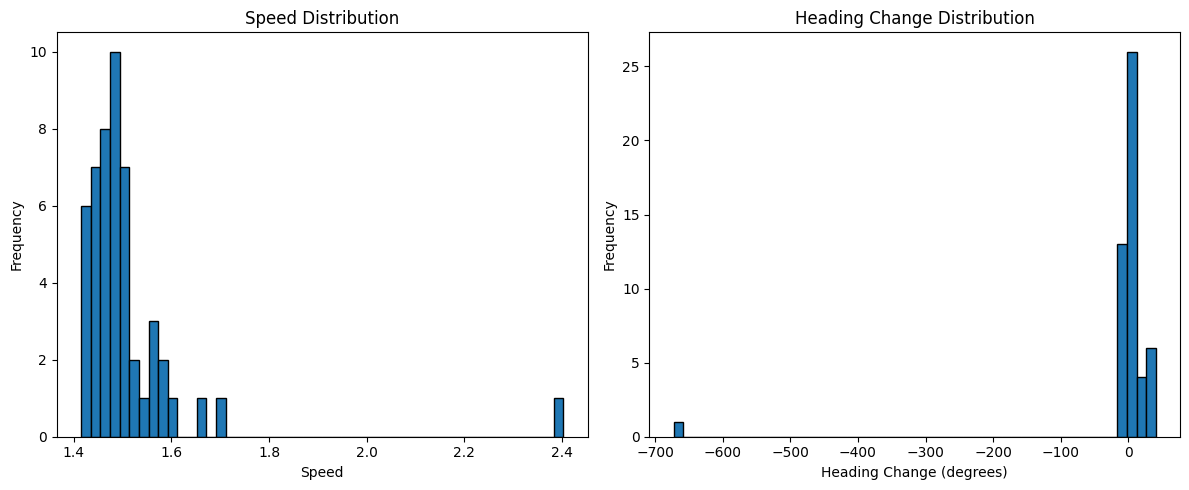

2025-04-05 17:29:57 - INFO - CSV 파일 로딩 시작: c:\Users\kimbo\NNL\AI-PDR_GPS-GT\data\test_data\3f_looking02.csv
2025-04-05 17:29:57 - INFO - CSV 파일 로딩 완료: 2726 행
2025-04-05 17:29:57 - INFO - 컬럼 이름 재정의 완료
2025-04-05 17:29:57 - INFO - 시간 데이터 전처리 시작
2025-04-05 17:29:57 - INFO - 시간 데이터 전처리 완료
2025-04-05 17:29:57 - INFO - GPS 데이터 전처리 시작
2025-04-05 17:29:57 - INFO - ENU 좌표 변환 시작
2025-04-05 17:30:02 - INFO - ENU 좌표 변환 완료
2025-04-05 17:30:02 - INFO - GPS 데이터 전처리 완료
2025-04-05 17:30:02 - INFO - 가속도 벡터 크기 계산 시작
2025-04-05 17:30:02 - INFO - 가속도 벡터 크기 계산 완료
2025-04-05 17:30:02 - INFO - 속도 및 헤딩 계산 시작
2025-04-05 17:30:02 - INFO - 속도 및 헤딩 계산 시작
2025-04-05 17:30:02 - INFO - 속도 및 헤딩 계산 완료
2025-04-05 17:30:02 - INFO - 속도 및 헤딩 계산 완료
2025-04-05 17:30:02 - INFO - 전체 전처리 완료


2/2 [==============================] - 0s 16ms/step


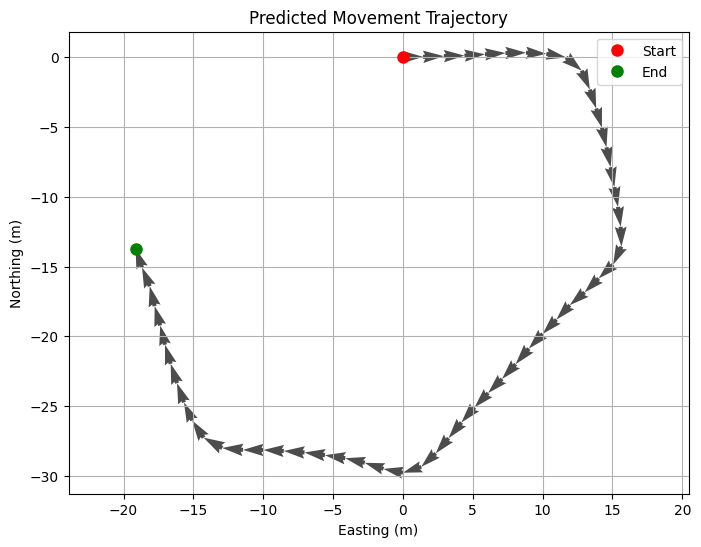

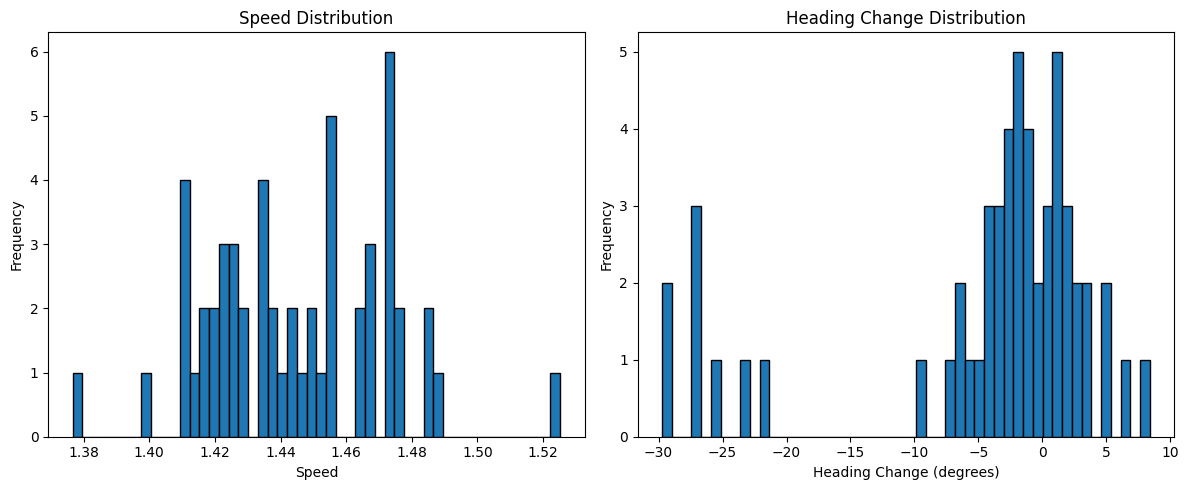

In [1]:
from src.data_processor import DataProcessor
from src.model_trainer import ModelTrainer
from src.trajectory_predictor import TrajectoryPredictor
import numpy as np
import os

# 현재 main.py 파일의 디렉토리를 기준으로 프로젝트 루트 경로 설정
# BASE_DIR = os.path.dirname(os.path.abspath(__file__))
BASE_DIR = os.getcwd()

def main():
    # ============================================================
    # 1. 학습 데이터 로딩 및 전처리
    # ============================================================
    learn_data_paths = [
        os.path.join(BASE_DIR, 'data', 'learn_data', 'Basket_1.csv'),
        os.path.join(BASE_DIR, 'data', 'learn_data', 'Basket_2.csv'),
        os.path.join(BASE_DIR, 'data', 'learn_data', 'Soccer_looking1.csv'),
        os.path.join(BASE_DIR, 'data', 'learn_data', 'Soccer_looking2.csv'),
        os.path.join(BASE_DIR, 'data', 'learn_data', 'Soccer_looking3.csv'),
        os.path.join(BASE_DIR, 'data', 'learn_data', 'Soccer_looking4.csv'),
        os.path.join(BASE_DIR, 'data', 'learn_data', 'Soccer_swing1.csv'),
        os.path.join(BASE_DIR, 'data', 'learn_data', 'Soccer_swing2.csv'),
        os.path.join(BASE_DIR, 'data', 'learn_data', 'Soccer_swing3.csv'),
        os.path.join(BASE_DIR, 'data', 'learn_data', 'Soccer_swing4.csv')
    ]
    
    df_list = []
    for path in learn_data_paths:
        if os.path.exists(path):
            df = DataProcessor.load_and_preprocess_csv(path)
            df_list.append(df)
        else:
            print(f"파일을 찾을 수 없습니다: {path}")
    
    # ============================================================
    # 2. 슬라이딩 윈도우 방식으로 X, Y 데이터 생성
    # ============================================================
    X_list, Y_list = [], []
    for df in df_list:
        X_sub, Y_sub = DataProcessor.make_XY_using_dataframe(df)
        X_list.append(X_sub)
        Y_list.append(Y_sub)
    
    # 만약 데이터를 불러오지 못했다면 종료
    if not X_list:
        print("학습 데이터를 불러오지 못했습니다.")
        return

    X = np.concatenate(X_list, axis=0)  # 최종 X: (전체 샘플 수, window_size, 센서 채널 수)
    Y = np.concatenate(Y_list, axis=0)  # 최종 Y: (전체 샘플 수, 2) → [속도, 헤딩 변화량]
    
    # ============================================================
    # 3. 모델 학습
    # ============================================================
    total_samples, window_size, num_features = X.shape
    trainer = ModelTrainer(window_size, num_features, epochs=100, batch_size=128)
    history, _ = trainer.train_model(X, Y)
    trainer.plot_training_history(history)
    
    # 모델 저장
    model_path = trainer.save_model()
    print("모델이 저장되었습니다:", model_path)
    
    # ============================================================
    # 4. 테스트 데이터에 대해 예측 및 이동 경로 시각화
    # ============================================================
    test_paths = [
        os.path.join(BASE_DIR, 'data', 'test_data', '3f_1.csv'),
        os.path.join(BASE_DIR, 'data', 'test_data', '3f_2.csv'),
        os.path.join(BASE_DIR, 'data', 'test_data', '3f_swing1.csv'),
        os.path.join(BASE_DIR, 'data', 'test_data', '3f_swing2.csv'),
        os.path.join(BASE_DIR, 'data', 'test_data', '3f_looking01.csv'),
        os.path.join(BASE_DIR, 'data', 'test_data', '3f_looking02.csv')
    ]
    for test_path in test_paths:
        if os.path.exists(test_path):
            df_test = DataProcessor.load_and_preprocess_csv(test_path, skiprows=50)
            predictor = TrajectoryPredictor(trainer.model, trainer.scaler_acc, trainer.scaler_gyro, trainer.scaler_ori)
            predictor.predict_and_plot_trajectory(df_test)
        else:
            print(f"테스트 파일을 찾을 수 없습니다: {test_path}")

if __name__ == '__main__':
    main(),
